<a href="https://colab.research.google.com/github/colaresm/Applied-computational-intelligence/blob/main/HW2_Prevendo_a_idade_de_um_abalone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 
import seaborn as sns
from scipy.stats import skew 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prevendo a idade de um abalone
O objeto do presente estudo  são os abalones, moluscos comestíveis, o qual visa realizar a predição de suas respectivas idades, a qual exige que a concha do animal seja cortada  para a contagem dos seus anés, o que não pode ser feito com o animal vivo. Então, objetiva-se aplicar técnicas de regressão linear, modelos penalizados e PLS para  gerar um modelo linear tendo suas características físicas como entrada, bem como avaliar a precisão das predições obtidas. 

In [ ]:
variaveis = ['Length','Diameter','Height','Whole_weight','Shucked_weight','Viscera_weight','Shell_weight','Age']
path ="/content/drive/MyDrive/datasets_ml/abalone_csv.csv"
dados = pd.read_csv(path)
dados['Age'] = dados['Class_number_of_rings']+1.5
dados.drop('Class_number_of_rings', axis = 1, inplace = True)
dados

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,8.5
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,12.5
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,11.5
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,10.5
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,11.5


Execute uma análise exploratória dos dados e pré-processe os preditores para remover possível assimetria em sua distribuição. Com base nos preditores transformados, comente sobre a presença de relacionamentos entre pares de preditores (estime a matriz de correlação). Além disso, as relações entre os preditores e o resultado são individualmente lineares (estimar todas as correlações entre o preditor e o resultado)?

## Pré-processamento

a transformação de Yeo-Johnson permite estabilizar a variância   e aproximar os dados  à distribuição normal, além de  melhorar a  correlação  entre variáveis. Onde $y_i$ corresponde ao vetor de dados que será transformado e $\lambda$ pode ser qualquer número real,. 

$$
y_i^{\lambda }=\left\{\begin{matrix}
 \left (\left ( y_i+1 \right )^{\lambda } -1 \right )/\lambda  & se \ \lambda  \neq 0,y\geq 0 \\ 
  log\left ( y_i +1 \right ) &se \ \lambda = 0,y \geq  0 \\ 
-\left [\left ( -yi+1 \right )  ^{\left ( 2-\lambda \right )}-1\right ]/\left ( 2-\lambda \right ) &  se \ \lambda  \neq 2,y < 0       \\ 
 - log\left ( -y_i +1 \right ) & se \ \lambda  = 2,y < 0 
\end{matrix}\right.
$$

In [ ]:
from scipy import stats
#variaveis = ['Length','Diameter','Height','Whole_weight','Shucked_weight','Viscera_weight','Shell_weight','Class_number_of_rings']
LongestShell,x = stats.yeojohnson(dados['Length'])
Diameter,x = stats.yeojohnson(dados['Diameter'])
Height,x = stats.yeojohnson(dados['Height'])
WholeWeight,x = stats.yeojohnson(dados['Whole_weight'])
ShuckedWeight,x = stats.yeojohnson(dados['Shucked_weight'])
VisceraWeight,x = stats.yeojohnson(dados['Viscera_weight'])
ShellWeight,x = stats.yeojohnson(dados['Shell_weight'])
Age,x = stats.yeojohnson(dados['Age'])

varss = { 
    'Length': LongestShell,
    'Diameter': Diameter,
     'Height': Height,
    'Diameter': Diameter,
     'Whole_weight': WholeWeight,
    'Shucked_weight': ShuckedWeight,
     'Viscera_weight': VisceraWeight,
     'Shell_weight': ShellWeight,
      'Age': Age,
   
 }
c = { 'LongestShell': np.array(LongestShell) }
dadosprocessados = pd.DataFrame(data=varss,columns=variaveis)
dadosprocessados
#dadosprocessados['Type'] = dados['Type']

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age
0,0.888380,0.664630,0.084098,0.420374,0.186795,0.088366,0.129183,2.467296
1,0.589568,0.411339,0.080161,0.204693,0.091304,0.045403,0.065112,2.001861
2,1.146789,0.833515,0.113927,0.525756,0.208463,0.117794,0.171306,2.150686
3,0.841390,0.664630,0.106738,0.421730,0.180515,0.098139,0.132872,2.214695
4,0.540196,0.389464,0.072138,0.187610,0.082811,0.037423,0.051937,2.001861
...,...,...,...,...,...,...,...,...
4172,1.281563,0.935469,0.134501,0.648221,0.277885,0.177890,0.196369,2.273273
4173,1.383701,0.900680,0.113927,0.691011,0.315217,0.164051,0.203442,2.214695
4174,1.425970,1.026069,0.159806,0.797388,0.357678,0.203143,0.231251,2.150686
4175,1.535268,1.063795,0.124395,0.757293,0.360231,0.189682,0.224432,2.214695


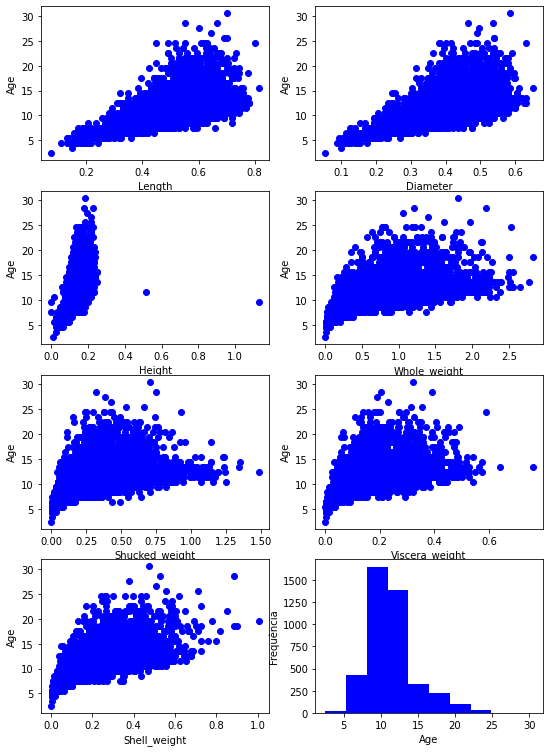

In [ ]:
fig, axs = plt.subplots(4, 2,figsize=(9, 13))
for j in range(0,2):     
    axs[0, j].scatter(dados[variaveis[j]], dados['Age'],color='b')
    axs[0, j].set(xlabel=variaveis[j], ylabel=variaveis[-1]) 
for j in range(0,2):     
    axs[1, j].scatter(dados[variaveis[j+2]], dados['Age'],color='b')
    axs[1, j].set(xlabel=variaveis[j+2], ylabel=variaveis[-1]) 
for j in range(0,2):     
    axs[2, j].scatter(dados[variaveis[j+4]], dados['Age'],color='b')
    axs[2, j].set(xlabel=variaveis[j+4], ylabel=variaveis[-1]) 
for j in range(0,1):     
    axs[3, j].scatter(dados[variaveis[j+6]], dados['Age'],color='b')
    axs[3, j].set(xlabel=variaveis[j+6], ylabel=variaveis[-1])  
for j in range(0,1):     
    axs[3, 1].hist(dados['Age'],color='b')
    axs[3, 1].set(xlabel=variaveis[j+7], ylabel='Frequência')
plt.savefig('scatterplotbruto.png') 

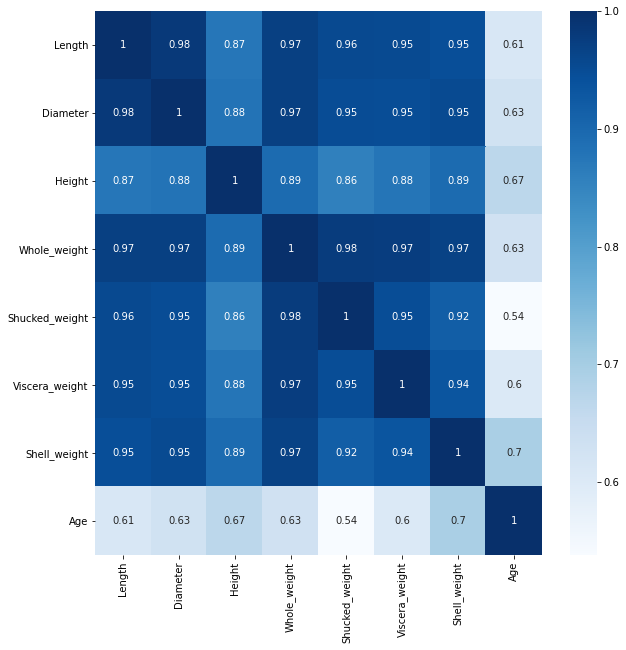

In [ ]:
plt.figure(figsize=(10, 10))
corr = dadosprocessados.corr()
_ = sns.heatmap(corr, annot=True,cmap='Blues' )
plt.savefig('matrizcorrelacao.pdf') 

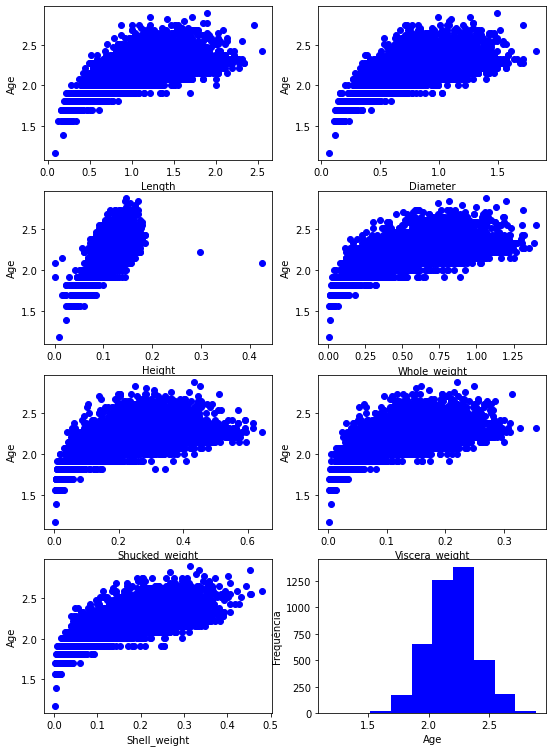

In [ ]:
fig, axs = plt.subplots(4, 2,figsize=(9, 13))
for j in range(0,2):     
    axs[0, j].scatter(dadosprocessados[variaveis[j]], dadosprocessados['Age'],color='b')
    axs[0, j].set(xlabel=variaveis[j], ylabel=variaveis[-1]) 
for j in range(0,2):     
    axs[1, j].scatter(dadosprocessados[variaveis[j+2]], dadosprocessados['Age'],color='b')
    axs[1, j].set(xlabel=variaveis[j+2], ylabel=variaveis[-1]) 
for j in range(0,2):     
    axs[2, j].scatter(dadosprocessados[variaveis[j+4]], dadosprocessados['Age'],color='b')
    axs[2, j].set(xlabel=variaveis[j+4], ylabel=variaveis[-1]) 
for j in range(0,1):     
    axs[3, j].scatter(dadosprocessados[variaveis[j+6]], dadosprocessados['Age'],color='b')
    axs[3, j].set(xlabel=variaveis[j+6], ylabel=variaveis[-1])  
for j in range(0,1):     
    axs[3, 1].hist(dadosprocessados['Age'],color='b')
    axs[3, 1].set(xlabel=variaveis[j+7], ylabel='Frequência')
plt.savefig('scatterplot.png') 

1-Use os preditores transformados no conjunto de treinamento para aprender um modelo de regressão linear comum e teste o modelo usando o conjunto de teste (lembre-se de aplicar o mesmo pré-processamento usado no conjunto de treinamento). Compare o desempenho do modelo obtido no conjunto de teste com as estimativas que você obteria usando um esquema de reamostragem como validação cruzada de 5 ou 10 vezes: use o $RMSE$ e o $R^2$.

## Regressão linear por mínimos quadrados
A regressão linear é uma abordagem muito simples para o aprendizado supervisionado. É uma abordagem muito simples para prever uma resposta quantitativa  de uma saída $Y$ no
tendo como  base em uma única variável preditora  de entrada $X$. é preciso que exista uma relação  aproximadamente linear entre $X$ e $Y$:
\begin{equation}
Y \approx \beta_0+\beta_1X
\end{equation}

Onde $\beta_0$ e $\beta_1$ são duas constantes desconhecidas a seren determinadas no processo, elas representam os termos de interceptação e inclinação no modelo linear, respectivamente. Os dados são utilizados para estimar os coeficientes. $\hat{\beta}_0$ e $\hat{\beta}_1$, que serão utilizados para determinar o nosso  estimados $\hat{y}$. Nesse processo existe a presença de um erro irredutível, o objetivo consiste em minimizar a soma dos erros quadrados:
\begin{equation}
J\left ( \beta_0,\beta_1 \right ) =   \sum_{i=1}^{N}e_i^2 = \sum_{i=1}^{N}\left ( y_i-\hat{\beta}_0-\hat{\beta}_1x_i \right )^2
\end{equation}
\begin{equation}
 \frac{\partial J}{\partial \beta_0} = \frac{1}{2}\sum_{i=1}^{N}-2\left ( y_i- \hat{\beta}_0-\hat{\beta}_1x_i\right ) 
=0
\end{equation}

\begin{equation}
 \frac{\partial J}{\partial \beta_1} = \frac{1}{2}\sum_{i=1}^{N}-2x_i\left ( y_i- \hat{\beta}_0-\hat{\beta}_1x_i\right ) =0
\end{equation}

Obtem-se duas equações com duas  incógnita, resolvendo o sistema de equações tem-se que:
\begin{equation}
 \beta_1 = \frac{\sum \left ( x_i -\bar{x}\right )\left (y_i -\bar{y}  \right )}{\sum \left ( x_i-\bar{x} \right )^2} = \frac{cov(x,y)}{var(x)}
\end{equation}
\begin{equation}
 \beta_0 = \bar{y}-\beta{1}\bar{x}
\end{equation}

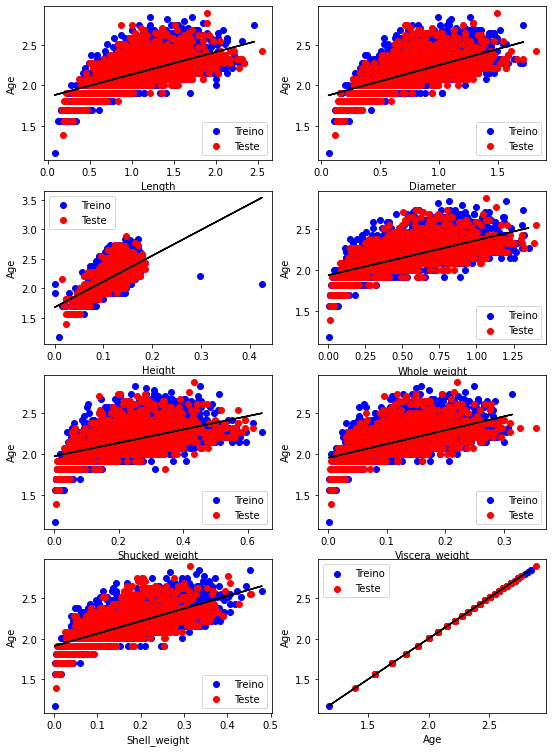

In [ ]:
fig, axs = plt.subplots(4, 2,figsize=(9, 13))
for j in range(0,2):     
    x = dadosprocessados[variaveis[j]].values.reshape(-1, 1)
    y =dadosprocessados['Age'].values.reshape(-1, 1)
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.30, random_state = 0)
    linearRegressor = LinearRegression()
    linearRegressor.fit(xTrain, yTrain)
    yPrediction = linearRegressor.predict(xTest)
    axs[0, j].scatter(xTrain, yTrain, color = 'b',label='Treino')
    axs[0, j].scatter(xTest, yTest, color = 'r',label='Teste')
    axs[0, j].plot(xTrain, linearRegressor.predict(xTrain), color = 'black')
    axs[0, j].set(xlabel=variaveis[j], ylabel=variaveis[-1]) 
    axs[0, j].legend() 
for j in range(0,2):     
    x = dadosprocessados[variaveis[j+2]].values.reshape(-1, 1)
    y =dadosprocessados['Age'].values.reshape(-1, 1)
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.30, random_state = 0)
    linearRegressor = LinearRegression()
    linearRegressor.fit(xTrain, yTrain)
    yPrediction = linearRegressor.predict(xTest)
    axs[1, j].scatter(xTrain, yTrain, color = 'b',label='Treino')
    axs[1, j].scatter(xTest, yTest, color = 'r',label='Teste')
    axs[1, j].plot(xTrain, linearRegressor.predict(xTrain), color = 'black')
    axs[1, j].set(xlabel=variaveis[j+2], ylabel=variaveis[-1]) 
    axs[1, j].legend()
for j in range(0,2):     
    x = dadosprocessados[variaveis[j+4]].values.reshape(-1, 1)
    y =dadosprocessados['Age'].values.reshape(-1, 1)
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.30, random_state = 0)
    linearRegressor = LinearRegression()
    linearRegressor.fit(xTrain, yTrain)
    yPrediction = linearRegressor.predict(xTest)
    axs[2, j].scatter(xTrain, yTrain, color = 'b',label='Treino')
    axs[2, j].scatter(xTest, yTest, color = 'r',label='Teste')
    axs[2, j].plot(xTrain, linearRegressor.predict(xTrain), color = 'black')
    axs[2, j].set(xlabel=variaveis[j+4], ylabel=variaveis[-1])
    axs[2, j].legend()
for j in range(0,2):     
    x = dadosprocessados[variaveis[j+6]].values.reshape(-1, 1)
    y =dadosprocessados['Age'].values.reshape(-1, 1)
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.30, random_state = 0)
    linearRegressor = LinearRegression()
    linearRegressor.fit(xTrain, yTrain)
    yPrediction = linearRegressor.predict(xTest)
    axs[3, j].scatter(xTrain, yTrain, color = 'b',label='Treino')
    axs[3, j].scatter(xTest, yTest, color = 'r',label='Teste')
    axs[3, j].plot(xTrain, linearRegressor.predict(xTrain), color = 'black')
    axs[3, j].set(xlabel=variaveis[j+6], ylabel=variaveis[-1])  
    axs[3, j].legend()
plt.savefig('reg.png') 

## Regressão linear múltipla
Agora iremos criar um modelo que tem como entrada as caracteríscticas dos abalones e sua saída a idade

\begin{equation}
Y \approx \beta_0+\beta_1X_1+\beta_2X_2+...+\beta_NX_N
\end{equation}

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
X = dadosprocessados.drop(['Age'], axis=1)
Y = dadosprocessados
X_train, X_test, y_train, y_test = train_test_split(  X, Y, test_size=0.30, random_state=42) 
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
mean_absolute_error(y_test, regr.predict(X_test))

0.01206961757735338

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, regr.predict(X_test))

0.9493890097663054

  Uma métrica qualitativa de  avaialiação do desempenho é o erro quadrático médio (MSE) é dado pela soma dos erros ao quadrado  dividido pelo total de amostras
  
 \begin{equation}
 MSE = \frac{1}{N}\sum_{i=1}^{N}\left ( y_i-\hat{y}_i \right )^2
 \end{equation}
 
  Tirando a raíz quadrada do  $MSE$ defini-se o $RMSE$ :
 
 
  \begin{equation}
 RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}\left ( y_i-\hat{y}_i \right )^2}
 \end{equation}
 
  O $RMSE$ mede a performace do modelo, o $R^2$ representa a proporção da variância para uma variável dependente que é explicada por uma variável independente em um modelo de regressão, o qual é difinido pela da seguinte forma:
   \begin{equation}
 R^2 =1 -\frac{RSS}{TSS}
 \end{equation}
 onde $RSS=  \sum_{i=1}^{N}(y_i-\hat{y}_i)^2$, que pode ser interpretado como  uma medida dispersão dos dados gerados pelo em relação aos originais e $TSS = \sum_{i=1}^{N}\left ( y_i -\bar{y}\right )$, que mede a variância em relação a saída.  

In [ ]:
for j in range(0,8):
    x = dadosprocessados[variaveis[j]].values.reshape(-1, 1)
    y =dadosprocessados['Age'].values.reshape(-1, 1)
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.25, random_state = 0)
    linearRegressor = LinearRegression()
    linearRegressor.fit(xTrain, yTrain)
    yPrediction = linearRegressor.predict(yTrain)
    model = LinearRegression()
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    r2_treino = cross_val_score(model, xTrain, yTrain,cv=cv, n_jobs=-1)
    RMSE_treino = cross_val_score(model, xTrain, yTrain,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
    #teste
    linearRegressor.fit(xTest, yTest)
    yPrediction = linearRegressor.predict(xTest)
    model = LinearRegression()
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    r2_teste = cross_val_score(model, xTest, yTest,cv=cv, n_jobs=-1)
    RMSE_teste = cross_val_score(model, xTest, yTest,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
    print(variaveis[j],'X Idade','R2 treino;',round(r2_treino.mean(),2),'R2 teste:',round(r2_teste.mean(),2),'RMSE treino',round(np.sqrt(-RMSE_treino.mean()),4),'RMSE teste:',round(np.sqrt(-RMSE_teste.mean()),4))
 
    

Length X Idade R2 treino; 0.36 R2 teste: 0.4 RMSE treino 0.1516 RMSE teste: 0.1504
Diameter X Idade R2 treino; 0.38 R2 teste: 0.42 RMSE treino 0.1487 RMSE teste: 0.1479
Height X Idade R2 treino; 0.41 R2 teste: 0.52 RMSE treino 0.1445 RMSE teste: 0.1337
Whole_weight X Idade R2 treino; 0.38 R2 teste: 0.42 RMSE treino 0.1484 RMSE teste: 0.1478
Shucked_weight X Idade R2 treino; 0.28 R2 teste: 0.31 RMSE treino 0.161 RMSE teste: 0.161
Viscera_weight X Idade R2 treino; 0.35 R2 teste: 0.4 RMSE treino 0.1527 RMSE teste: 0.1509
Shell_weight X Idade R2 treino; 0.47 R2 teste: 0.5 RMSE treino 0.1375 RMSE teste: 0.1372
Age X Idade R2 treino; 1.0 R2 teste: 1.0 RMSE treino 0.0 RMSE teste: 0.0


2-Use os preditores transformados no conjunto de treinamento para aprender um modelo de regressão linear penalizado por L2 e teste o modelo usando o conjunto de teste (lembre-se de aplicar o mesmo pré-processamento que você usou no conjunto de treinamento). Determine o valor ideal de λ usando uma validação cruzada de 5 ou 10 vezes com base no RMSE (você só pode usar o conjunto de treinamento nesta fase, e seu espaço de pesquisa λ deve consistir em pelo menos 10 valores). Relatório sobre o processo (mostrar o perfil da validação cruzada, tanto nos termos do RMSE quanto do $R^02$). Relate a precisão ($RMSE$ e $R^2$) obtida no conjunto de teste.

## Modelos penalizados- Ridge Regression 
Os coeficientes produzidos pela regressão de mínimos quadrados ordinários são imparciais e, este modelo também tem a variância mais baixa. Dado que o $MSE$ consiste em uma combinação de variância e bias, é possível gerar  modelos com MSEs menores, faz com que estimativas dos parâmetros obitidos sejam tendenciosas. O normal que ocorra um pequeno aumento no viés inplique em uma queda considerável na variância, produzindo um $MSE$ menor do que os coeficientes de regressão de mínimos quadrados. Uma consequência das grandes correlações entre as variâncias do preditor é que a variância pode se tornar muito grande.  
Uma possível solução seria penalizar a soma dos erros quadráticos. No presente estudo utilizou-se a Ridge regression, a qual  adiciona uma penalidade na soma do parâmetro de regressão quadrado:


\begin{equation}
RSS_{L2} = \sum_{i=1}^{N}\left ( y_i -\hat{y}_i\right )+\lambda\sum_{j=1}^{N}\beta^2_j
\end{equation}
O subíndice $L2$ significa que o modelo possui  uma penalidade de segunda ordem nas estimativas dos parâmetros, que significa que as estimativas dos parâmetros só são permitidas se tornarem grandes se houver uma redução proporcional no RSS.Este método reduz as estimativas para 0 à medida que a penalidade $\lambda$ torna-se  grande.Ao penalizar o moelo, realiza-se uma compensação entre a variância e o viés do modelo.


In [ ]:
from sklearn.linear_model import Ridge
def ridge(x, y,alpha,preditor):
    X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
    rr = Ridge(alpha=alpha) 
    rr.fit(X_train, y_train)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    RMSE = cross_val_score(rr, X_train, y_train,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
    RMSE = np.sqrt(-RMSE.mean())
    return RMSE

In [ ]:
RMSEval = []
lambdas  = [ ]
l2 = []
alpha = np.linspace(0.001,0.1,10)
for j in range(0,8):
    for i in range(0,10):
        RMSEval.append(ridge(dadosprocessados[variaveis[j]].values.reshape(-1, 1), dadosprocessados['Age'].values.reshape(-1, 1),alpha[i],variaveis[0]))
        lambdas.append(alpha[i])
    print(round(min(RMSEval),4), lambdas[RMSEval.index(min(RMSEval))])
    l2.append(lambdas[RMSEval.index(min(RMSEval))])
print(l2)

0.1505 0.1
0.1477 0.05600000000000001
0.144 0.012
0.144 0.012
0.144 0.012
0.144 0.012
0.1362 0.001
0.0 0.001
[0.1, 0.05600000000000001, 0.012, 0.012, 0.012, 0.012, 0.001, 0.001]


In [ ]:
def ridge2(x, y,alpha,preditor):
    X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
    rr = Ridge(alpha=alpha) 
    rr.fit(X_train, y_train)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    RMSE = cross_val_score(rr, X_test, y_test,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=-1)
    RMSE = np.sqrt(-RMSE.mean())
    return RMSE

In [ ]:
def ridge3(x, y,alpha,preditor):
    X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
    rr = Ridge(alpha=alpha) 
    rr.fit(X_train, y_train)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    r2 = cross_val_score(rr,X_test,y_test,cv=cv, n_jobs=-1)
    r2 = r2.mean()
    return r2

In [ ]:
RMSEval = []
r2val = []
for j in range(0,8):
    RMSEval.append(ridge2(dadosprocessados[variaveis[j]].values.reshape(-1, 1), dadosprocessados['Age'].values.reshape(-1, 1),l2[j],variaveis[0]))
    r2val.append(ridge3(dadosprocessados[variaveis[j]].values.reshape(-1, 1), dadosprocessados['Age'].values.reshape(-1, 1),l2[j],variaveis[0]))
    print(l2[j])
print(np.round(RMSEval,4))
print(np.round(r2val,2))

0.1
0.05600000000000001
0.012
0.012
0.012
0.012
0.001
0.001
[0.1533 0.1506 0.1372 0.1502 0.1629 0.1533 0.1403 0.    ]
[0.37 0.39 0.5  0.4  0.29 0.37 0.47 1.  ]


## Regressão Ridge múltipla

In [ ]:
RMSEval = []
lambdas  = [ ]
l2 = []
alpha = np.linspace(0.001,0.1,10)
for j in range(0,1):
    for i in range(0,10):
        RMSEval.append(ridge(dadosprocessados.drop(['Age'], axis=1), dadosprocessados['Age'].values.reshape(-1, 1),alpha[i],variaveis[0]))
        lambdas.append(alpha[i])
    print(round(min(RMSEval),4), lambdas[RMSEval.index(min(RMSEval))])
    l2.append(lambdas[RMSEval.index(min(RMSEval))])
print(l2)

0.1227 0.05600000000000001
[0.05600000000000001]


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)
rr = Ridge(alpha=l2) 
rr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
mean_absolute_error(y_test, rr.predict(X_test))

0.012460447461756967

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, rr.predict(X_test))

0.9474651808156209

3-Use os preditores transformados no conjunto de treinamento para aprender um modelo de regressão PLS ou PCR e teste o modelo usando o conjunto de teste (lembre-se de aplicar o mesmo pré-processamento usado no conjunto de treinamento). Determine o número ideal de componentes usando uma validação cruzada de 5 ou 10 vezes com base no RMSE (você só pode usar o treinamento na fase). Reportonprocess (mostrar o per ﬁ l de validação cruzada, tanto em termos de RMSE quanto de R2). Relate a precisão (RMSE e R2) obtida no conjunto de teste.

In [ ]:
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression, PLSSVD

X  = dadosprocessados.drop(['Age'], axis=1).astype('float64')
y= dadosprocessados['Age']
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=1)


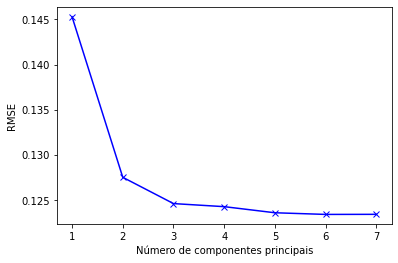

In [ ]:
from sklearn.preprocessing import scale 

n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

rmse = []

for i in np.arange(1, 8):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(-score))

# Plot results
plt.plot(np.arange(1, 8), np.array(rmse), '-x',color='b')
plt.xlabel('Número de componentes principais')
plt.ylabel('RMSE')
 
plt.savefig('pls.pdf') 

In [ ]:
pls = PLSRegression(n_components=3)
pls.fit(scale(X_train), y_train)
mean_squared_error(y_test, pls.predict(scale(X_test)))


0.015550921670900936